In [ ]:
import jax
import jax.numpy as jnp
import jax.lax as lax
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
def visualize_fn(fn, l=-10, r=10, n=1000):
    x = np.linspace(l, r, num=n)
    y = fn(x)
    plt.plot(x, y); plt.show()

In [ ]:
x = np.arange(10)
x[0] = 10
y = jnp.arange(10)

#Operação não permitida! Arrays são imutáveis
y[0] = 10

TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [ ]:
z = jnp.arange(10)
w = z.at[0].set(100)
print(z)
print(w)

[0 1 2 3 4 5 6 7 8 9]
[100   1   2   3   4   5   6   7   8   9]


## Comparação de perfomance

In [ ]:

tamanho = 3000
x_jnp = jnp.arange(tamanho)
x_np = np.arange(tamanho)

%timeit np.dot(x_np, x_np.T)
%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready()

The slowest run took 4.17 times longer than the fastest. This could mean that an intermediate result is being cached.
14.5 µs ± 8.87 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
85.8 µs ± 18.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Jit

In [ ]:
def relu(x):
  return jnp.array(x+10)

seed = 0
#Toda a geração de numeros aleatórios precisa de uma key
key = jax.random.PRNGKey(seed)

#Função aprimorada, tem mais desempenho
relu_jit = jax.jit(relu)

x = jax.random.normal(key, 1000)

%timeit relu_jit(x).block_until_ready()
%timeit relu(x).block_until_ready()




98.3 µs ± 32.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
325 µs ± 14.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
# Jit não é valido para qualquer tipo de função!


## Grad

In [ ]:
# Agiliza a descida gradiente
# Modo automático

def mse(x):
  return jnp.sum((x**2)) # x1 * 2 + x2 * 2 + x3 * 2 + x4 * 2 -> Derivada da função UAU

x = jnp.arange(4.)
loss_func = mse


loss_func_grad = jax.grad(loss_func)

#Calcula automaticamente o gradiente, considerando que x é a diferença entre as saidas do modelo e as entradas esperadas
print(loss_func_grad(x))


[0. 2. 4. 6.]


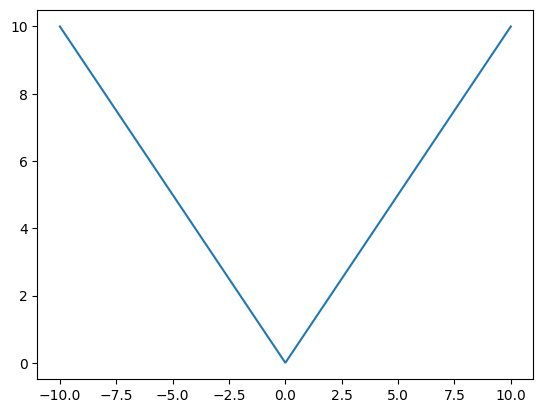

Array(1., dtype=float32, weak_type=True)

In [ ]:
#Função com devirada indefinida para x = 0
func = lambda x: jnp.abs(x)

#Calcula o gradiente
func_grad = jax.grad(func)


visualize_fn(func)

#Define a derivada de 0 para 1, por convenção e praticidade
func_grad(0.)

## Vmap

In [ ]:
#Escrever suas próprias funções como se estivesse tratando com um escalar
W = jax.random.normal(key, (150, 150))
x_batched = jax.random.normal(key, (50, 150)) #Tratar como "batch", + RAPIDO

def mult_matrix(x):
  return jnp.dot(W, x)

In [ ]:
def vector_mult_matrix(x):
  return jnp.stack([mult_matrix(obj) for obj in x])

print("Vetorizado:")
%timeit vector_mult_matrix(x_batched).block_until_ready()

Vetorizado:
4.15 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
#Usando jit
mult_matrix_jit = jax.jit(mult_matrix)

def vector_mult_matrix_jit(x):
  return jnp.stack([mult_matrix_jit(obj) for obj in x])

print("Vetorizado com jit:")
%timeit vector_mult_matrix_jit(x_batched)

Vetorizado com jit:
4.33 ms ± 77 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
#Usando vmap

def vmap_mult_matrix(x):
  return jax.vmap(mult_matrix)(x)

#Perceba que a sintaxe é: jax.vmap(função aplicada a apenas um valor)(vetor)
%timeit vmap_mult_matrix(x_batched)

734 µs ± 63 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Lax


> Numpy -> Lax -> XLA



In [ ]:
# Lax é mais restrititivo, porém mais rápido
print(jnp.add(1, 1.0))
print(jax.lax.add(1, 1.0))
#Erro! O tipo dos dados precisa ser os mesmos

2.0


ValueError: Cannot lower jaxpr with verifier errors:
	op requires the same element type for all operands and results
		at loc("jit(add)/jit(main)/add"(callsite("<module>"("<ipython-input-13-492d42f549d6>":3:6) at callsite("InteractiveShell.run_code"("/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py":3553:20) at callsite("InteractiveShell.run_ast_nodes"("/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py":3473:24) at callsite("InteractiveShell.run_cell_async"("/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py":3257:29) at callsite("_pseudo_sync_runner"("/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py":78:8) at callsite("InteractiveShell._run_cell"("/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py":3030:19) at callsite("InteractiveShell.run_cell"("/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py":2975:21) at callsite("ZMQInteractiveShell.run_cell"("/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py":528:15) at callsite("IPythonKernel.do_execute"("/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py":383:26) at "Kernel.execute_request"("/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py":730:28))))))))))))
Define JAX_DUMP_IR_TO to dump the module.